# Attention-Weighted Integrated Gradients for Target-Aware Cyberbullying Detection

## Colab Setup

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive

drive.mount('/content/drive')

# Folder to mount
FOLDERNAME = 'cs329t/project/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Ensure the Python interpreter of the Colab VM can load python files
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# cd into the dataset
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/cs329t/project


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#Imports
import sys
import pickle
import importlib
import subprocess
from pathlib import Path

# if running from within truera repo and want to use latest code, use this:
sys.path.insert(0, str(Path("../..").resolve()))

def install_if_not_installed(packages):
  """Install the given packages if they are not already installed."""

  for package in packages:
    if isinstance(package, tuple):
      package_name, package_package = package
    else:
      package_name = package
      package_package = package

    print(f"{package_name} ... ", end='')

    try:
      importlib.import_module(package_name)
      print("already installed")

    except:
      print(f"installing from {package_package}")
      subprocess.check_call(
          [sys.executable, "-m", "pip", "install", package_package]
      )

def load_or_make(filename: Path, loader, maker=None, saver=None, downloader=None):
  """Load something from a `filename` using `loader` if the file exists, 
  otherwise make it using `maker`, save it using `saver`, and return it."""

  print(f"loading {filename} ... ", end="")

  if filename.exists():
    print("from file")
    return loader(filename)
  
  if maker is not None:
    print("using maker")
    thing = maker()
    saver(filename, thing)
    return thing

  if downloader is not None:
    print("using downloader")
    downloader(filename)
    return loader(filename)

  raise ValueError("provide a maker/saver or downloader.")

install_if_not_installed(
    [("trulens", "git+https://github.com/truera/trulens.git@piotrm/vis/output-detect"),
     "transformers",
     "pandas",
     "numpy",
     "domonic",
     "parmap",
     "fairlearn"]
)

# Configure trulens
import os
os.environ['TRULENS_BACKEND']='torch'

from IPython.display import display
import matplotlib.pyplot as plt
import torch
import pandas as pd
import numpy as np
from pathlib import Path
import re

from torch.utils.data import DataLoader
from pandas import Series
from typing import Union
import parmap

trulens ... installing from git+https://github.com/truera/trulens.git@piotrm/vis/output-detect
transformers ... installing from transformers
pandas ... already installed
numpy ... already installed
domonic ... installing from domonic
parmap ... installing from parmap
fairlearn ... installing from fairlearn


## Twitter Roberta BASE Sentiment Model

In [ ]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved

print(f"{t} memory in total of which {r} is reserved by PyTorch and {a} is available")

15843721216 memory in total of which 0 is reserved by PyTorch and 0 is available


In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

# Wrap all of the necessary components.
class TwitterSentiment:
    # device = 'cpu'
    device = 'cuda:0'
    MODEL = f'cardiffnlp/twitter-roberta-base-sentiment-latest'
    model = AutoModelForSequenceClassification.from_pretrained(MODEL, output_attentions=True).to(device)
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    @staticmethod
    def tokenize(inputs):
        return TwitterSentiment \
            .tokenizer(inputs, padding=True, return_tensors='pt') \
            .to(TwitterSentiment.device)

    labels = ['negative', 'neutral', 'positive']
    NEGATIVE = labels.index('negative')
    NEUTRAL = labels.index('neutral')
    POSITIVE = labels.index('positive')

task = TwitterSentiment()

Downloading:   0%|          | 0.00/929 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [ ]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved

print(f"{t} memory in total of which {r} is reserved by PyTorch and {a} is available")

15843721216 memory in total of which 555745280 is reserved by PyTorch and 499894784 is available


## Hatespeech Dataset

In [ ]:
# Flip the labels
def flip_labels(labels):
  flipped_labels = list()
  for label in labels:
    if label == 0:
      flipped_labels.append(1)
    else:
      flipped_labels.append(0)
  return flipped_labels

In [ ]:
import csv

def load_csv(file_path):
  with open(file_path, newline='') as csv_file:
    reader = csv.reader(csv_file)
    csv_data = list(reader)
  return csv_data

csv_data = load_csv('data/target_test_clean.csv')

In [ ]:
def format_data(csv_data):
  formatted_dataset = list()
  for example in csv_data[1:]:
    text = example[0]
    targets = [word for word in text.split() if word.startswith('@') or word.startswith('.@')]
    polarity = example[-1]
    formatted_dataset.append([text, targets, polarity])
  return formatted_dataset
  
dataset = format_data(csv_data)
ground_truth_labels = [int(example[-1]) for example in dataset]
ground_truth_labels = flip_labels(ground_truth_labels)

## Evaluate Baseline

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def model_predict(task, dataset):
  model_preds = list()
  # Cannot parallelize (CUDA out-of-memory error)
  for example in dataset:
    model_input = task.tokenize(example[0])
    model_output = task.model(**model_input)
    model_pred = task.labels[model_output.logits.argmax(axis=1)]
    if model_pred == 'negative':
      model_preds.append(0)
    elif model_pred == 'neutral':
      model_preds.append(1)
    elif model_pred == 'positive':
      model_preds.append(1)
  return model_preds

def model_accuracy(model_preds, dataset):
  dataset_labels = [int(example[-1]) for example in dataset]
  accuracy = accuracy_score(dataset_labels, model_preds)
  return accuracy

def compute_metrics(gt_labels, preds):
  acc = accuracy_score(gt_labels, preds)
  prec = precision_score(gt_labels, preds)
  rec = recall_score(gt_labels, preds)
  f1 = f1_score(gt_labels, preds)
  print('Accuracy:', acc)
  print('Precision:', prec)
  print('Recall:', rec)
  print('F1 Score:', f1)
  return acc, prec, rec, f1

In [ ]:
baseline_preds = model_predict(task, dataset)
baseline_preds = flip_labels(baseline_preds)
print('Vanilla model metrics on non-neutralized dataset:')
compute_metrics(ground_truth_labels, baseline_preds)

Vanilla model metrics on non-neutralized dataset:
Accuracy: 0.7885806007796377
Precision: 0.7351973684210527
Recall: 0.8654404646660213
F1 Score: 0.7950200088928413


## Fairness

### Identify biased targets

In [ ]:
def target_sentiments(task, dataset):
  positive_targets = list()
  neutral_targets = list()
  negative_targets = list()
  for example in dataset:
    targets = example[1]
    for target in targets:
      input = task.tokenize(target)
      output = task.model(**input)
      pred = task.labels[output.logits.argmax(axis=1)]
      if pred == 'negative':
        negative_targets.append((target, output[0].tolist()[0][0]))
      elif pred == 'neutral':
        neutral_targets.append((target, output[0].tolist()[0][1]))
      elif pred == 'positive':
        positive_targets.append((target, output[0].tolist()[0][2]))
  negative_targets.sort(key=lambda x: x[1], reverse=True)
  neutral_targets.sort(key=lambda x: x[1], reverse=True)
  positive_targets.sort(key=lambda x: x[1], reverse=True)
  return negative_targets, neutral_targets, positive_targets

negative_targets, neutral_targets, positive_targets = target_sentiments(task, dataset)

In [ ]:
print('Number of negative targets found :', len(negative_targets))
print('Top 5 most negative targets', negative_targets[:5])

print('Number of neutral targets found :', len(neutral_targets))
print('Top 5 most neutral targets', neutral_targets[:5])

print('Number of positive targets found :', len(positive_targets))
print('Top 5 most positive targets', positive_targets[:5])

Number of negative targets found : 32
Top 5 most negative targets [('@DumbPeopleAsf', 1.898148775100708), ('@_theworst__:', 1.749870777130127), ('@FuckedYaBxtch:', 1.7437466382980347), ('@crooksandliars', 1.6455061435699463), ('@crooksandliars', 1.6455061435699463)]
Number of neutral targets found : 6561
Top 5 most neutral targets [('@HayleyKiyoko', 2.105206251144409), ('@Amish_Drive_By:', 2.0862185955047607), ('@_Geidner_', 2.0658788681030273), ('.@RickReedMedia', 2.0423269271850586), ('@Rick_Turner:', 2.0150043964385986)]
Number of positive targets found : 18
Top 5 most positive targets [('@BestVinesEver', 2.3773114681243896), ('@_RatedGorgeous', 2.022413969039917), ('@amazingatheist', 1.6356178522109985), ('@uniqueblessed:', 1.5953482389450073), ('@GoodBecameGreat', 1.5624502897262573)]


### Neutralize targets

In [ ]:
def neutralize_dataset(dataset):
  neutralized_dataset = list()
  for example in dataset:
    text = example[0]
    targets = example[1]
    polarity = example[-1]
    for target in targets:
      text = text.replace(target, '@username')
    neutralized_dataset.append([text, targets, polarity])
  neutralized_dataset = [example for example in neutralized_dataset if '@username' in example[0]]
  return neutralized_dataset

neutralized_dataset = neutralize_dataset(dataset)
ground_truth_labels = [int(example[-1]) for example in neutralized_dataset]
# ground_truth_labels = flip_labels(ground_truth_labels)

In [ ]:
neutralized_preds = model_predict(task, neutralized_dataset)
neutralized_preds = flip_labels(neutralized_preds)
print('Vanilla model metrics on neutralized dataset:')
compute_metrics(ground_truth_labels, neutralized_preds)

Vanilla model metrics on neutralized dataset:
Accuracy: 0.7953027860925628
Precision: 0.7383177570093458
Recall: 0.8811833171677983
F1 Score: 0.8034490382489499


### Biased datasets

In [ ]:
def create_biased_dataset(dataset, new_target):
  biased_dataset = list()
  for example in dataset:
    text = example[0]
    targets = example[1]
    polarity = example[-1]
    text = text.replace('@username', new_target)
    biased_dataset.append([text, targets, polarity])
  return biased_dataset

negative_dataset = create_biased_dataset(neutralized_dataset, negative_targets[0][0])
positive_dataset = create_biased_dataset(neutralized_dataset, positive_targets[0][0])
biased_datasets = {'@DumbPeopleAsf (negative)': negative_dataset,
                   '@BestVinesEver (positive)': positive_dataset}

### Disparity of logits histogram

In [ ]:
def model_logits(task, dataset):
  logits_list = list()
  for example in dataset:
    input = task.tokenize(example[0])
    output = task.model(**input)
    logits = output['logits'].detach().to('cpu')
    logits_list.append(logits)
  models_logits = np.stack(list(map(torch.Tensor.numpy, logits_list)))
  models_logits = models_logits.reshape((models_logits.shape[0], 3))
  return models_logits

biased_logits = {username: model_logits(task, biased_dataset) for username, biased_dataset in biased_datasets.items()}

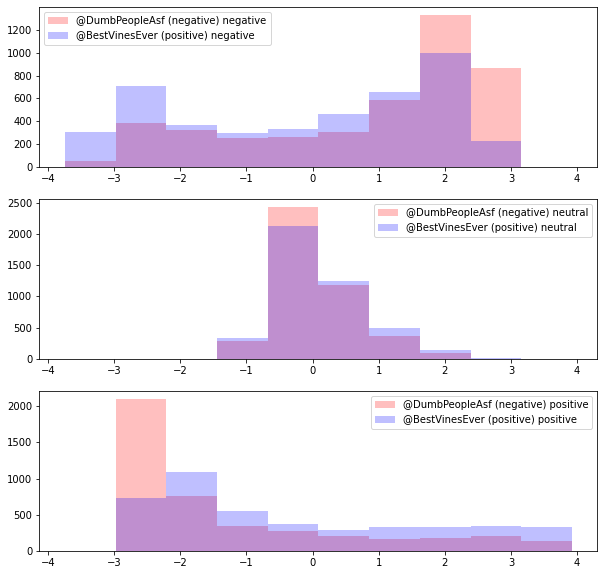

In [ ]:
amin = min(logits.min() for logits in biased_logits.values())
amax = max(logits.max() for logits in biased_logits.values())

# Figure showing the histogram of logits for each of the three classes
colors = {'@DumbPeopleAsf (negative)': 'red', '@BestVinesEver (positive)': 'blue'}
fig, axs = plt.subplots(3,1, figsize=(10,10))
for idx, label in zip([task.NEGATIVE, task.NEUTRAL, task.POSITIVE], task.labels):
    for username, logits in biased_logits.items():
        axs[idx].hist(logits[:, idx], bins=10, alpha=0.25, label=f"{username} {label}", color=colors[username], range=(amin, amax))
    axs[idx].legend()

### Most disparate tweets

In [ ]:
from trulens.nn.models import get_model_wrapper

task.wrapper = get_model_wrapper(task.model, input_shape=(None, task.tokenizer.model_max_length), device=task.device)

INFO: lib level=1
INFO: root level=30
INFO: Detected pytorch backend for <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'>.
INFO: Using backend Backend.PYTORCH.
INFO: If this seems incorrect, you can force the correct backend by passing the `backend` parameter directly into your get_model_wrapper call.


In [ ]:
from trulens.visualizations import NLP

V = NLP(
    wrapper=task.wrapper,
    labels=task.labels,
    decode=lambda x: task.tokenizer.decode(x),
    tokenize=task.tokenize,
    # huggingface models can take as input the keyword args as per produced by their tokenizers.

    input_accessor=lambda x: x['input_ids'],
    # for huggingface models, input/token ids are under input_ids key in the input dictionary

    output_accessor=lambda x: x['logits'],
    # and logits under 'logits' key in the output dictionary

    hidden_tokens=set([task.tokenizer.cls_token_id, task.tokenizer.bos_token_id, task.tokenizer.eos_token_id, task.tokenizer.pad_token_id])
    # do not display these tokens
)

In [ ]:
# Top 10 most disparate tweets
def most_disparate_tweets(biased_datasets, biased_logits, num_tweets=10):
  disparate_idxs = np.argsort(abs(biased_logits['@DumbPeopleAsf (negative)'] - biased_logits['@BestVinesEver (positive)']).sum(axis=1))[::-1]
  negative_disparate_tweets = list()
  positive_disparate_tweets = list()
  for tweet_idx in disparate_idxs:
    if len(negative_disparate_tweets) == num_tweets:
      break
    if biased_datasets['@DumbPeopleAsf (negative)'][tweet_idx][0].count('@') > 1:
      continue
    negative_disparate_tweets.append(biased_datasets['@DumbPeopleAsf (negative)'][tweet_idx][0])
    positive_disparate_tweets.append(biased_datasets['@BestVinesEver (positive)'][tweet_idx][0])
  return negative_disparate_tweets, positive_disparate_tweets

negative_disparate_tweets, positive_disparate_tweets = most_disparate_tweets(biased_datasets, biased_logits)
V.tokens_stability(
    texts1 = negative_disparate_tweets,
    texts2 = positive_disparate_tweets
)

## Robustness

### Integrated Gradients baseline

In [ ]:
from trulens.utils.nlp import token_baseline

# Get token IDs for '@username to add to baseline
tokenized_target = task.tokenize(' @username')
target_token_ids = tokenized_target['input_ids'].tolist()[0][1:3]

inputs_baseline_ids, inputs_baseline_embeddings = token_baseline(
    keep_tokens=set([task.tokenizer.cls_token_id, task.tokenizer.bos_token_id, task.tokenizer.eos_token_id] + target_token_ids),
    # Which tokens to preserve.
    replacement_token=task.tokenizer.pad_token_id,
    # What to replace tokens with.
    input_accessor=lambda x: x.kwargs['input_ids'],
    ids_to_embeddings=task.model.get_input_embeddings()
    # Callable to produce embeddings from token ids.
)

In [ ]:
from trulens.utils.typing import ModelInputs

tokenized_example = task.tokenize(neutralized_dataset[85][0])
print('originals=', task.tokenizer.batch_decode(tokenized_example['input_ids']))

baseline_word_ids = inputs_baseline_ids(model_inputs=ModelInputs(kwargs=tokenized_example))
print('baselines=', task.tokenizer.batch_decode(baseline_word_ids))

originals= ["<s>RT @username I bet Bear Grylls' barbecues are awful. Everyone expecting burgers and sausages, whilst he roasts dog shits and boils pin…</s>"]
baselines= ['<s><pad> @username<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad></s>']


### Integrated Gradients

In [ ]:
from trulens.nn.distributions import LinearDoi
from trulens.nn.quantities import LambdaQoI, ComparativeQoI
from trulens.nn.attribution import Cut, OutputCut, InputAttribution

# Example tweets
neutralized_tweets = [neutralized_dataset[85][0], neutralized_dataset[190][0]]

# LinearDoi is the same as Integrated Gradients
attr_cut = Cut('roberta_embeddings_word_embeddings')
doi = LinearDoi(baseline=inputs_baseline_embeddings,  resolution=50, cut=attr_cut)

# Lambda QoI (max(positive, neutral) - negative)
def custom_qoi(logits):
  max_neutral_positive = torch.maximum(logits[:, 1], logits[:, 2])
  negative = logits[:, 0]
  difference = max_neutral_positive - negative
  return torch.sum(difference)
lambda_qoi = LambdaQoI(custom_qoi)
# Comparative QoI (Not used)
# comparative_qoi = ComparativeQoI(task.POSITIVE, task.NEGATIVE)

infl = InputAttribution(
    model = task.wrapper,
    doi=doi,
    doi_cut=attr_cut,
    qoi=lambda_qoi,
    qoi_cut=OutputCut(accessor=lambda o: o['logits'])
)
display(
    V.tokens(neutralized_tweets, attributor=infl),
)

In [ ]:
display(
    V.tokens(["I hope @SConsul dies. Today is a wonderful and amazing day with beautiful weather."], attributor=infl),
)

### Token Attribution based Sentiment Analysis (Same as baseline)

Given the completeness property of integrated gradients, the attributions must sum up to the output logits of the model

In [ ]:
def evaluate_vanilla_attribution(task, dataset):
  model_scores = list()
  # Cannot parallelize (CUDA out-of-memory error)
  with torch.no_grad():
    for example in dataset:
      model_input = task.tokenize(example[0])
      model_output = task.model(**model_input)
      model_logits = model_output.logits
      negative_score = model_logits[0][0]
      neutral_score = model_logits[0][1]
      positive_score = model_logits[0][2]
      max_neutral_positive_score = max(neutral_score, positive_score)
      attr_score = max_neutral_positive_score - negative_score
      model_scores.append(attr_score)
  return model_scores

In [ ]:
def score_to_prediction(scores, threshold=0):
  model_preds = list()
  for score in scores:
    if score <= threshold:
      model_preds.append(0)
    else:
      model_preds.append(1)
  return model_preds

In [ ]:
vanilla_scores = evaluate_vanilla_attribution(task, neutralized_dataset)
vanilla_preds = score_to_prediction(vanilla_scores, threshold=0)
vanilla_preds = flip_labels(vanilla_preds)
print('Vanilla model metrics on neutralized dataset:')
compute_metrics(ground_truth_labels, vanilla_preds)

Vanilla model metrics on neutralized dataset:
Accuracy: 0.7953027860925628
Precision: 0.7383177570093458
Recall: 0.8811833171677983
F1 Score: 0.8034490382489499


### Attention-Weighted Token Attribution based Sentiment Analysis

In [ ]:
from trulens.nn.backend import get_backend
from trulens.utils.typing import nested_cast, ModelInputs

B = get_backend()

def to_numpy(input):
  return np.array(nested_cast(B, input, np.ndarray))

def get_token_attr_attn(task, attributor, text, head_mode, layer_mode):
  tokenized_text = task.tokenize(text)
  decoded_text = task.tokenizer.batch_decode(tokenized_text['input_ids'][0])
  model_inputs = ModelInputs(kwargs=tokenized_text)
  model_attr = attributor._attributions(model_inputs)
  numpy_attr = to_numpy(model_attr.attributions)[0, 0]
  token_attr = numpy_attr[0].sum(axis=1)
  attribution_list = list()

  for token_idx in range(len(decoded_text)):
    token = decoded_text[token_idx]
    attr = token_attr[token_idx]
    attribution_list.append((token, attr))
  
  attention = task.model(tokenized_text['input_ids'])['attentions']
  # username token is 48852
  try:
    target_idx = tokenized_text['input_ids'][0].tolist().index(48852)
  except:
    return None, None
    
  with torch.no_grad():
    num_heads=12
    num_layers = len(attention)
    inp_len = attention[0].shape[-1]
    head_attn = torch.zeros([num_layers,inp_len]).to(task.device)
    attn = torch.zeros([inp_len]).to(task.device)
    for layer, l_attn in enumerate(attention):
      for idx in range(inp_len):
        for h in range(num_heads):
          if idx is not target_idx:
            if head_mode is "max":
              head_attn[layer][idx] = max(head_attn[layer][idx],attention[layer][0,h,idx,target_idx])    
            elif head_mode is "avg":                
              head_attn[layer][idx] += attention[layer][0,h,idx,target_idx]/num_heads
        
        if layer_mode is "max":
          attn[idx] = max(attn[idx],head_attn[layer][idx])
        elif layer_mode is "avg":
          attn[idx] += head_attn[layer][idx]/num_layers

    normalized_attn = attn / (sum(attn) + 1e-7)
    return attribution_list, normalized_attn

In [ ]:
from tqdm import tqdm

def get_attn_weighted_scores(task, infl, dataset, head_mode, layer_mode):
  model_scores = list()
  for example_idx, example in tqdm(enumerate(dataset), total=len(dataset)):
    token_attr, attn = get_token_attr_attn(task, infl, example[0], head_mode, layer_mode)
    score = 0
    if head_mode is None and layer_mode is None:
      score = [attr for score, attr in token_attr]
    else:
      for token_idx, (token, attr) in enumerate(token_attr):
          score += attn[token_idx] * attr * attn.shape[0]
    model_scores.append(score)
  return model_scores

def get_attn_weighted_attrs(task, infl, dataset, head_mode, layer_mode):
  attn_weighted_attrs = list()
  for example in dataset:
    tweet = example[0]
    token_attr, attn = get_token_attr_attn(task, infl, tweet, head_mode, layer_mode)
    if head_mode is None and layer_mode is None:
      attn_weighted_attrs.append(token_attr)
    else:
      attn_weighted_attr = list()
      for token_idx, (token, attr) in enumerate(token_attr):
        attn_weighted_token_attr = attn[token_idx] * attr * attn.shape[0]
        attn_weighted_attr.append((token, attn_weighted_token_attr))
      attn_weighted_attrs.append(attn_weighted_attr)
  return attn_weighted_attrs

In [ ]:
attn_weighted_scores = get_attn_weighted_scores(task, infl, neutralized_dataset, 'max', 'max')

100%|██████████| 4343/4343 [30:42<00:00,  2.36it/s]


In [ ]:
attn_weighted_preds = score_to_prediction(attn_weighted_scores, threshold=0)
attn_weighted_preds = flip_labels(attn_weighted_preds)
print('AWIG model metrics on neutralized dataset:')
compute_metrics(ground_truth_labels, attn_weighted_preds)

AWIG model metrics on neutralized dataset:
Accuracy: 0.8047432650241768
Precision: 0.7463474025974026
Recall: 0.8918525703200776
F1 Score: 0.8126380910296068


# Adversarial Robustness

### Camouflage Attacks

In [ ]:
import random

def generate_adversarial_dataset(num_tweets):
  adv_dataset = list()
  positive_sentences_target = [
    'I love hanging out with @username.',
    '@username is amazing at sports.',
    'I appreciate @username for their awesome attitude.',
    'Thank you @username for a beautiful performance.',
    'I am fond of @username and their majestic hair.',
    'He enjoys his company with @username because they are an amazing singer.',
    'I treasure @username because they are my best friend.'
    'She adores @username for their incredible style.',
    'I want to relish in the glory that @username has brought home.',
    'There is no one more magnanimous than @username and certainly no one more kind.']
  negative_sentences_target = [
    'I hate spending time with @username.',
    '@username is awful at dancing.',
    'I wish @username would die because they are pathetic.',
    'He abhors @username for their terrible singing.',
    'I despise @username because they are cursed.',
    'She loathes @username for their repulsive breath.',
    'I scorn @username because they are disgusting.',
    'There is no one more miserable than @username because they are deplorable.',
    'I have nothing but utter disdain for @username and their personality.',
    'They think that @username is atrocious and hideous.']
  positive_sentences = [
    'I love the beautiful weather outside today.',
    'He is a very fascinating and marvelous swimmer.',
    'I believe that every day will be happy and wonderful.',
    'She cherishes every moment she has with her delightful brother.',
    'I want to ride in that dazzling car with that gorgeous woman.',
    'Some people are very charming, elegant, and alluring.',
    'I wish I could dance in a more elegant and graceful manner.',
    'Their baby is very adorable and has a pleasant aura.',
    'I love the delightful food at that heavenly restaurant.',
    'There is no place more captivating and brilliant than my house.']
  negative_sentences = [
    'I absolutely detest that pathetic little excuse of a human.',
    'He thinks that everyone is horrendous and terrible at rock climbing.',
    'I hate everyone and everything in existence, especially my loathsome cat.',
    'She is very ugly and outright disgusting in every possible way.',
    'I wish I could kill them myself because they are nasty and shameless.',
    'If there was a more abominable and revolting person, it would be them',
    'I believe that that dog is the most vile and vulgar thing to exist.',
    'The weather is very dreadful and unpleasant today.',
    'I look at them and see nothing by the most rotten and heinous people ever.',
    'Sometimes I wish they would just kill themselves because they are pitiful.']
  # Generate positive tweets
  for tweet_idx in range(num_tweets//2):
    positive_part = random.choice(positive_sentences_target)
    negative_part1 = random.choice(negative_sentences)
    negative_part2 = random.choice(negative_sentences)
    tweet = negative_part1 + ' ' + positive_part + ' ' + negative_part2
    adv_dataset.append([tweet, ['@username'], '1'])
  # Generate negative tweets
  for tweet_idx in range(num_tweets//2):
    negative_part = random.choice(negative_sentences_target)
    positive_part1 = random.choice(positive_sentences)
    positive_part2 = random.choice(positive_sentences)
    tweet = positive_part1 + ' ' + negative_part + ' ' + positive_part2
    adv_dataset.append([tweet, ['@username'], '0'])
  return adv_dataset

adv_dataset = generate_adversarial_dataset(1000)
adv_ground_truth_labels = [int(example[-1]) for example in adv_dataset]
adv_ground_truth_labels = flip_labels(adv_ground_truth_labels)

In [ ]:
baseline_adv_preds = model_predict(task, adv_dataset)
baseline_adv_preds = flip_labels(baseline_adv_preds)
print('Baseline model metrics on camouflage attack dataset:')
compute_metrics(adv_ground_truth_labels, baseline_adv_preds)

Baseline model metrics on camouflage attack dataset:
Accuracy: 0.036
Precision: 0.05725190839694656
Recall: 0.06
F1 Score: 0.05859375


In [ ]:
attn_weighted_adv_scores = get_attn_weighted_scores(task, infl, adv_dataset, 'max', 'max')

100%|██████████| 1000/1000 [09:55<00:00,  1.68it/s]


In [ ]:
attn_weighted_adv_preds = score_to_prediction(attn_weighted_adv_scores, threshold=0)
attn_weighted_adv_preds = flip_labels(attn_weighted_adv_preds)
print('AWIG model metrics on camouflage attack dataset:')
compute_metrics(adv_ground_truth_labels, attn_weighted_adv_preds)

AWIG model metrics on camouflage attack dataset:
Accuracy: 0.475
Precision: 0.4856815578465063
Recall: 0.848
F1 Score: 0.6176256372906045


### Vanilla vs Attention-Weighted attributions

In [ ]:
import matplotlib.pyplot as plt

def visualize_attributions(task, infl, dataset):
  # Vanilla token attributions
  vanilla_token_attrs = get_attn_weighted_attrs(task, infl, dataset, None, None)
  vanilla_token_attrs = vanilla_token_attrs[0]
  tokens = list()
  plot_tokens = list()
  vanilla_attrs = list()
  vanilla_plot_colors = list()
  for token_idx, (token, attr) in enumerate(vanilla_token_attrs):
    tokens.append(token+str(token_idx))
    plot_tokens.append(token)
    vanilla_attrs.append(attr.item())
    if vanilla_attrs[-1] >= 0:
      vanilla_plot_colors.append('lightgreen')
    else:
      vanilla_plot_colors.append('salmon')
  # Weighted token attributions
  weighted_token_attrs = get_attn_weighted_attrs(task, infl, dataset, 'max', 'max')
  weighted_token_attrs = weighted_token_attrs[0]
  weighted_attrs = list()
  weighted_plot_colors = list()
  for token_idx, (token, attr) in enumerate(weighted_token_attrs):
    weighted_attrs.append(attr.item())
    if weighted_attrs[-1] >= 0:
      weighted_plot_colors.append('g')
    else:
      weighted_plot_colors.append('r')
  # Draw the plot
  fig = plt.figure(figsize=(len(tokens)*1.25, 10))
  ax = fig.add_subplot(111)
  x_vals = np.array(list(range(len(tokens))))
  ax.bar(x_vals-0.2, vanilla_attrs, width=0.4, color=vanilla_plot_colors)
  ax.bar(x_vals+0.2, weighted_attrs, width=0.4, color=weighted_plot_colors)
  ax.set_xticks(x_vals)
  ax.set_xticklabels(plot_tokens)
  return ax

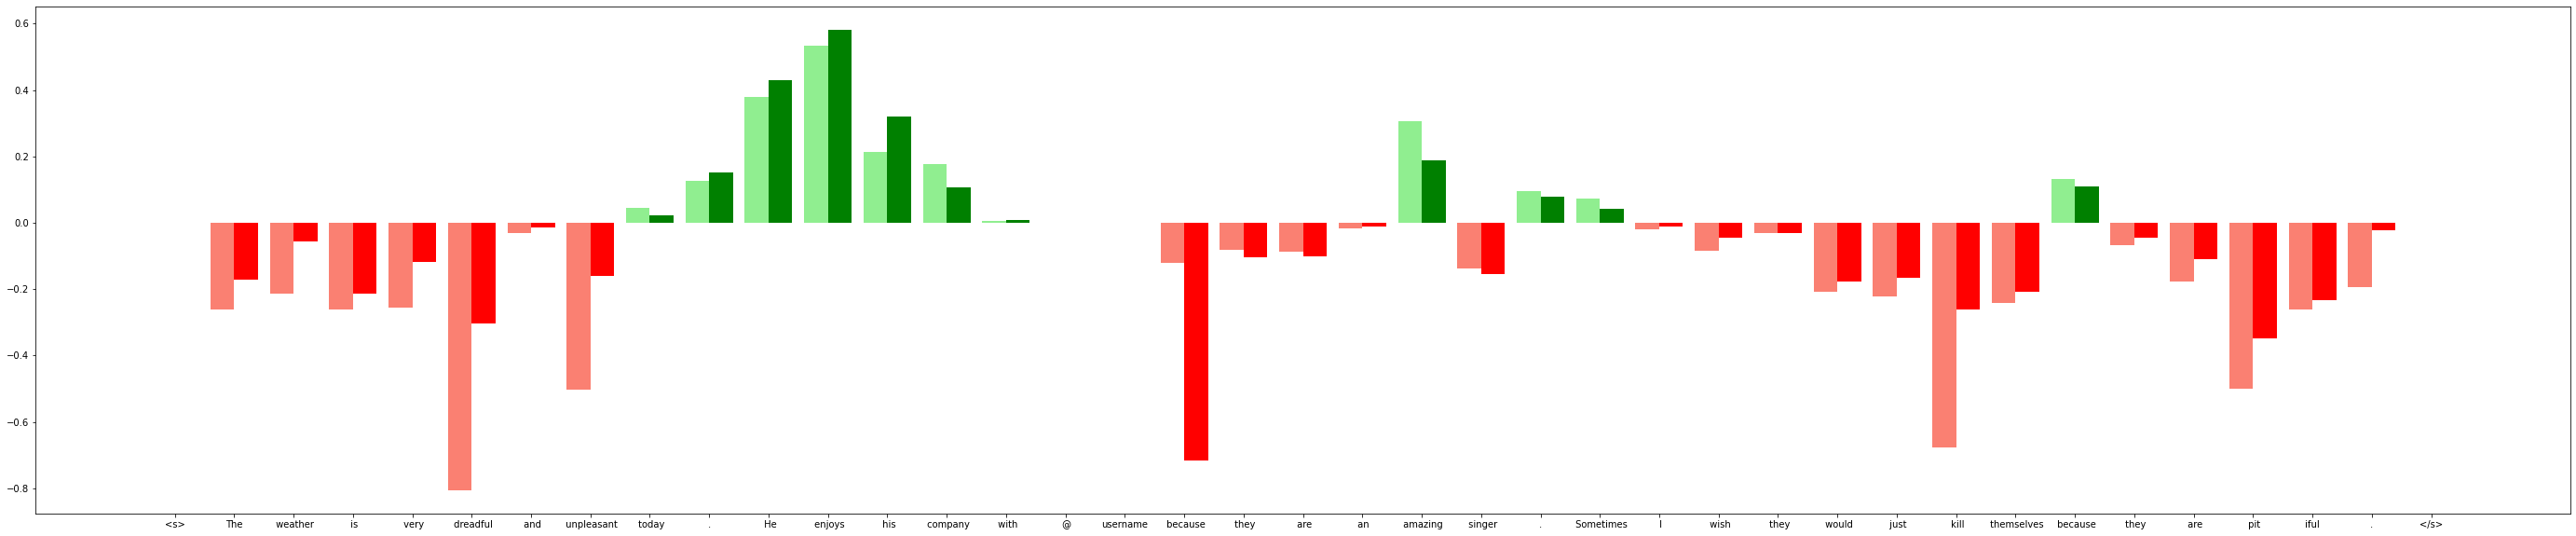

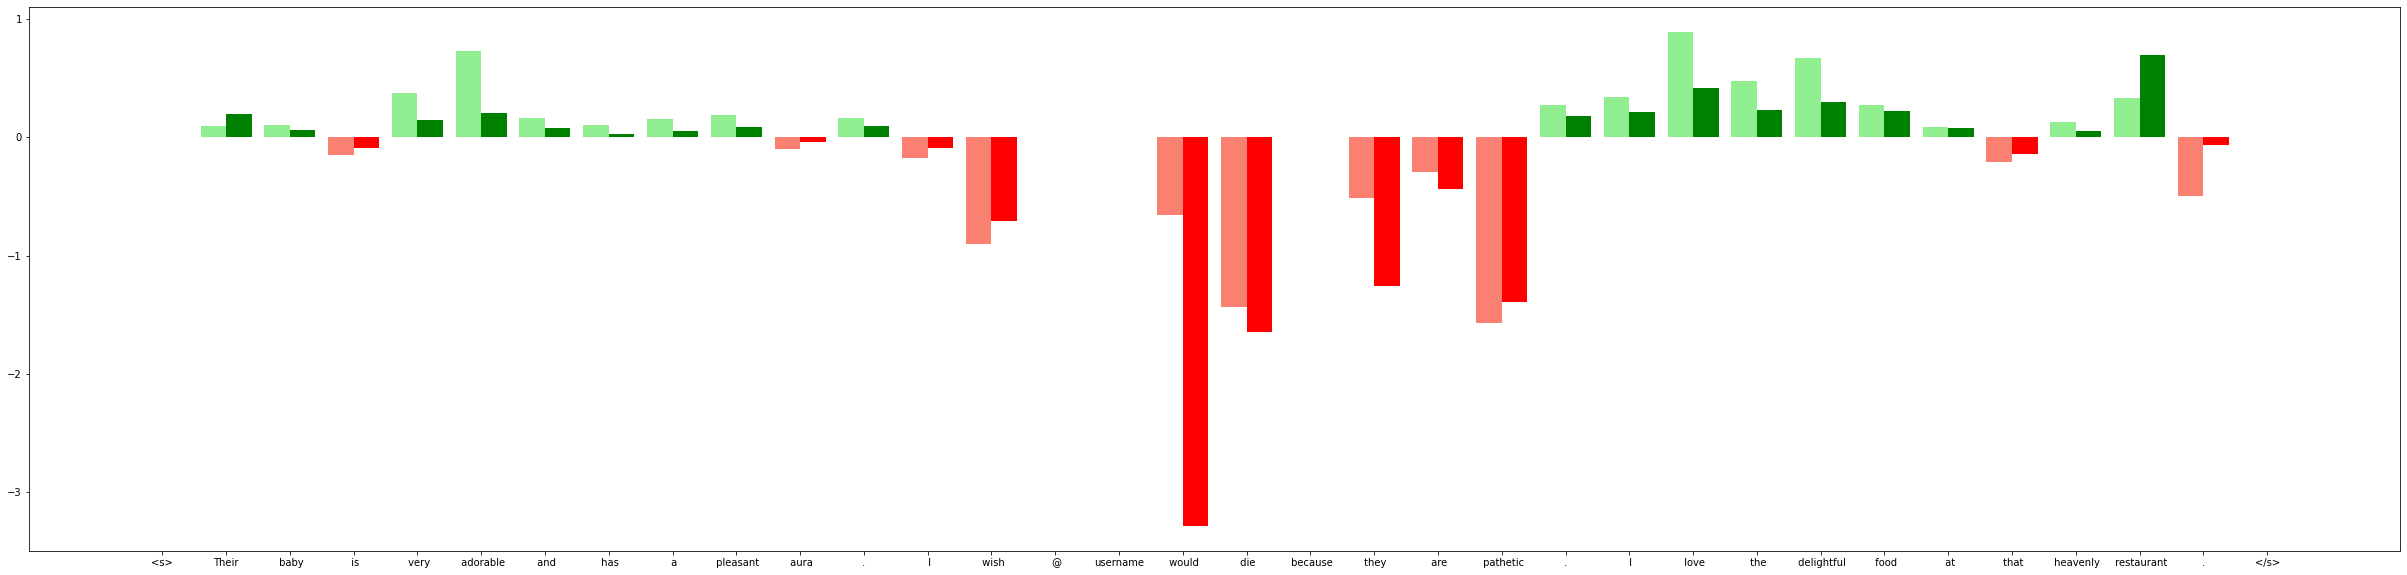

In [ ]:
adv_dataset_small = generate_adversarial_dataset(2)
for example in adv_dataset_small:
  plt.show(visualize_attributions(task, infl, [example]))

## TextAttack

In [ ]:
import pickle

In [ ]:
with open("data/a_textfooler.pkl", 'rb') as f:
        a_res = pickle.load(f)
print(len(a_res))
pert_dataset = []
for orig, pert, lbl in a_res:
    if int(lbl[1]) > -1:
        pert_dataset.append([pert, ['@username'], str(int(int(lbl[0])>0))])
print(len(pert_dataset))

for example in pert_dataset:
    start_idx = example[0].find("@")
    end_idx = example[0][start_idx:].find(" ")+start_idx
    print(example[0][start_idx:end_idx], "||", example[0][start_idx:])
    example[0] = example[0].replace(example[0][start_idx:end_idx], "@username")

In [ ]:
def text_attack_eval(pkl_file, attack_name,mode):
    with open(pkl_file, 'rb') as f:
        a_res = pickle.load(f)
    LEN = 50
    pert_dataset = []
    for orig, pert, lbl in a_res:
        if int(lbl[1]) > -1:
            pert_dataset.append([pert, ['@username'], str(int(int(lbl[0])>0))])
    
    for example in pert_dataset:
        start_idx = example[0].find("@")
        end_idx = example[0][start_idx:].find(" ")+start_idx
        example[0] = example[0].replace(example[0][start_idx:end_idx], "@username")

    pert_gt = [int(example[-1]) for example in pert_dataset][:LEN]
    f_pert_gt = flip_labels(pert_gt)
    
    orig_dataset = [[orig, ['@username'], str(int(int(lbl[0])>0))] for orig, pert, lbl in a_res]
    orig_dataset = neutralize_dataset(orig_dataset)[:LEN]

    orig_gt = [int(example[-1]) for example in orig_dataset]
    f_orig_gt = flip_labels(orig_gt)

    torch.cuda.empty_cache()
    if mode == "base_o":
        return compute_metrics(orig_gt, model_predict(task, orig_dataset))

    elif mode == "base_p":
        return compute_metrics(pert_gt, model_predict(task, pert_dataset))
    
    elif mode == "awig_o":
        return compute_metrics(orig_gt, score_to_prediction(get_attn_weighted_scores(task, infl, orig_dataset, 'max', 'max'), threshold=0))
    
    
    elif mode == "awig_p":
        return compute_metrics(pert_gt, score_to_prediction(get_attn_weighted_scores(task, infl, pert_dataset, 'max', 'max'), threshold=0))

    elif mode == "viz":
        for pert,orig in zip(pert_dataset[:2],orig_dataset[:2]):
            print("GT LABEL:",pert[2])
            print(pert[0])
            print(orig[0])
            plt.show(visualize_attributions(task, infl, [pert]))

In [ ]:
base_o = text_attack_eval('data/a_textfooler.pkl', "textfooler","base_o")
base_p = text_attack_eval('data/a_textfooler.pkl', "textfooler","base_p")

print("Change in Metrics")
print(f"Base Model - Acc: {(base_p[0]-base_o[0]):.4f} Prec:  {(base_p[1]-base_o[1]):.4f} Rec:  {(base_p[2]-base_o[2]):.4f} F1: {(base_p[3]-base_o[3]):.4f}")
    

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Accuracy: 0.2463768115942029
Precision: 0.25862068965517243
Recall: 0.625
F1 Score: 0.3658536585365854
Change in Metrics
Base Model - Acc: -0.7536 Prec:  -0.7414 Rec:  -0.3750 F1: -0.6341


In [ ]:
tf_awig_o = text_attack_eval('data/a_textfooler.pkl', "textfooler","awig_o")
tf_awig_p = text_attack_eval('data/a_textfooler.pkl', "textfooler","awig_p")
print("Change in Metrics")
print(f"Base Model - Acc: {(tf_awig_p[0]-tf_awig_o[0]):.4f} Prec:  {(tf_awig_p[1]-tf_awig_o[1]):.4f} Rec:  {(tf_awig_p[2]-tf_awig_o[2]):.4f} F1: {(tf_awig_p[3]-tf_awig_o[3]):.4f}")
    

100%|██████████| 69/69 [00:30<00:00,  2.23it/s]

Accuracy: 0.9420289855072463
Precision: 0.8709677419354839
Recall: 1.0
F1 Score: 0.9310344827586207


In [ ]:
base_o = text_attack_eval('data/a_deepwordbug_100.pkl', "DeepWordBug","base_o")
base_p = text_attack_eval('data/a_deepwordbug_100.pkl', "DeepWordBug","base_p")

print("Change in Metrics")
print(f"Base Model - Acc: {(base_p[0]-base_o[0]):.4f} Prec:  {(base_p[1]-base_o[1]):.4f} Rec:  {(base_p[2]-base_o[2]):.4f} F1: {(base_p[3]-base_o[3]):.4f}")
    

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Accuracy: 0.5942028985507246
Precision: 0.45
Recall: 0.75
F1 Score: 0.5625000000000001
Change in Metrics
Base Model - Acc: -0.4058 Prec:  -0.5500 Rec:  -0.2500 F1: -0.4375


In [ ]:
dwb_awig_o = text_attack_eval('data/a_deepwordbug_100.pkl', "DeepWordBug","awig_o")
dwb_awig_p = text_attack_eval('data/a_deepwordbug_100.pkl', "DeepWordBug","awig_p")
print("Change in Metrics")
print(f"Base Model - Acc: {(dwb_awig_p[0]-dwb_awig_o[0]):.4f} Prec:  {(dwb_awig_p[1]-dwb_awig_o[1]):.4f} Rec:  {(dwb_awig_p[2]-dwb_awig_o[2]):.4f} F1: {(dwb_awig_p[3]-dwb_awig_o[3]):.4f}")
    

100%|██████████| 69/69 [00:27<00:00,  2.49it/s]

Accuracy: 0.9420289855072463
Precision: 0.8709677419354839
Recall: 1.0
F1 Score: 0.9310344827586207


In [ ]:
base_o = text_attack_eval('data/a_bertattack.pkl', "BertAttack","base_o")
base_p = text_attack_eval('data/a_bertattack.pkl', "BertAttack","base_p")

print("Change in Metrics")
print(f"Base Model - Acc: {(base_p[0]-base_o[0]):.4f} Prec:  {(base_p[1]-base_o[1]):.4f} Rec:  {(base_p[2]-base_o[2]):.4f} F1: {(base_p[3]-base_o[3]):.4f}")
    

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Accuracy: 0.3188405797101449
Precision: 0.2982456140350877
Recall: 0.7083333333333334
F1 Score: 0.4197530864197531
Change in Metrics
Base Model - Acc: -0.6812 Prec:  -0.7018 Rec:  -0.2917 F1: -0.5802


In [ ]:
text_attack_eval('data/a_bertattack.pkl', "BertAttack","base")



 =====BertAttack Attack on Base Model ======
Base Model on orig dataset
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Base Model on pert dataset
Accuracy: 0.3188405797101449
Precision: 0.2982456140350877
Recall: 0.7083333333333334
F1 Score: 0.4197530864197531
Change in Metrics
Base Model - Acc: -0.6812 Prec:  -0.7018 Rec:  -0.2917 F1: -0.5802



In [ ]:
ba_awig_o = text_attack_eval('data/a_bertattack.pkl', "BertAttack","awig_o")
ba_awig_p = text_attack_eval('data/a_bertattack.pkl', "BertAttack","awig_p")
print("Change in Metrics")
print(f"Base Model - Acc: {(ba_awig_p[0]-ba_awig_o[0]):.4f} Prec:  {(ba_awig_p[1]-ba_awig_o[1]):.4f} Rec:  {(ba_awig_p[2]-ba_awig_o[2]):.4f} F1: {(ba_awig_p[3]-ba_awig_o[3]):.4f}")
    


100%|██████████| 69/69 [00:27<00:00,  2.54it/s]

Accuracy: 0.9420289855072463
Precision: 0.8709677419354839
Recall: 1.0
F1 Score: 0.9310344827586207


# Fairness Evaluation on Protected Attributes

### Setup

In [ ]:
# Save predictions
with open('./data/vanilla_preds.pkl', 'wb') as fp:
  pickle.dump(neutralized_preds, fp)

with open('./data/weighted_preds.pkl', 'wb') as fp:
  pickle.dump(attn_weighted_preds, fp)

In [ ]:
# Load predictions
with open('./data/vanilla_preds.pkl', 'rb') as fp:
  vanilla_preds = pickle.load(fp)
  vanilla_preds = flip_labels(vanilla_preds)

with open('./data/weighted_preds.pkl', 'rb') as fp:
  weighted_preds = pickle.load(fp)
  weighted_preds = flip_labels(weighted_preds)

In [ ]:
from fairlearn import metrics as fairness_metrics

def compute_fairness_metrics(y_true, y_pred, protected_attribute):
  dem_parity_diff = fairness_metrics.demographic_parity_difference(y_true, y_pred, sensitive_features=protected_attribute)
  dem_parity_ratio = fairness_metrics.demographic_parity_ratio(y_true, y_pred, sensitive_features=protected_attribute)
  equal_odd_diff = fairness_metrics.equalized_odds_difference(y_true, y_pred, sensitive_features=protected_attribute)
  equal_odd_ratio = fairness_metrics.equalized_odds_ratio(y_true, y_pred, sensitive_features=protected_attribute)
  false_negative_rate = fairness_metrics.false_negative_rate(y_true, y_pred)
  false_positive_rate = fairness_metrics.false_positive_rate(y_true, y_pred)
  true_negative_rate = fairness_metrics.true_negative_rate(y_true, y_pred)
  true_positive_rate = fairness_metrics.true_positive_rate(y_true, y_pred)
  print('Demographic Parity Difference:', dem_parity_diff)
  print('Demographic Parity Ratio:', dem_parity_ratio)
  print('Equalized Odds Difference:', equal_odd_diff)
  print('Equalized Odds Ratio:', equal_odd_ratio)
  print('False Negative Rate:', false_negative_rate)
  print('False Positive Rate:', false_positive_rate)
  print('True Negative Rate:', true_negative_rate)
  print('True Positive Rate:', true_positive_rate)

In [ ]:
def cyberbullying_attribute_ratio(sentiment_labels, attribute_labels, group1_name, group2_name):
  group1_count = len([attr for attr in attribute_labels if attr==group1_name])
  group2_count = len([attr for attr in attribute_labels if attr==group2_name])
  group1_neg_count = 0
  group2_neg_count = 0
  for sentiment, attribute in zip(sentiment_labels, attribute_labels):
    if attribute == group1_name and sentiment == 0:
      group1_neg_count += 1
    if attribute == group2_name and sentiment == 0:
      group2_neg_count += 1
  group1_ratio = group1_neg_count / group1_count
  group2_ratio = group2_neg_count / group2_count
  print(group1_name, '|', group1_neg_count, '/', group1_count, '| cyberbullying ratio:', group1_ratio)
  print(group2_name, '|', group2_neg_count, '/', group2_count, '| cyberbullying ratio:', group2_ratio)

In [ ]:
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

def tokenize_dataset(dataset_text):
  description_list = list()
  for description in dataset_text:
    description = re.sub('[^a-zA-Z]', ' ', description)
    description = description.lower()
    description = nltk.word_tokenize(description)
    lemma = nltk.WordNetLemmatizer()
    description = [lemma.lemmatize(word) for word in description]
    description = ' '.join(description)
    description_list.append(description)
  return description_list

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def bag_of_words(tokenized_dataset):
  max_features = 5000
  cv = CountVectorizer(max_features=max_features, stop_words = 'english')
  sparse_matrix = cv.fit_transform(tokenized_dataset).toarray()
  return sparse_matrix

In [ ]:
from xgboost import XGBClassifier

def train_classifier(data_x, data_y):
  model = XGBClassifier(random_state=1)
  model.fit(data_x, data_y)
  return model

def test_classifier(model, data_x):
  pred_y = model.predict(data_x)
  pred_y = [round(pred) for pred in pred_y]
  return pred_y

### Race

In [ ]:
from fairness import race_classification

race_classification.load_model()

In [ ]:
def predict_race(text):
  logits = race_classification.predict(text.split())
  if logits is None:
    return 'wae'
  # African-American English
  aae_score = logits[0]
  # White-Aligned English
  wae_score = logits[3]
  if aae_score > wae_score:
    return 'aae'
  else:
    return 'wae'

race_attribute = [predict_race(example[0]) for example in neutralized_dataset]

In [ ]:
cyberbullying_attribute_ratio(ground_truth_labels, race_attribute, 'aae', 'wae')

aae | 153 / 871 | cyberbullying ratio: 0.1756601607347876
wae | 2128 / 3472 | cyberbullying ratio: 0.6129032258064516


In [ ]:
print('Vanilla:')
compute_fairness_metrics(ground_truth_labels, vanilla_preds, race_attribute)
print('\nAttention-Weighted Integrated Gradients:')
compute_fairness_metrics(ground_truth_labels, weighted_preds, race_attribute)

Vanilla:
Demographic Parity Difference: 0.28498448470162485
Demographic Parity Ratio: 0.6412984303827814
Equalized Odds Difference: 0.04065617475060196
Equalized Odds Ratio: 0.8730531686358755
False Negative Rate: 0.11881668283220174
False Positive Rate: 0.28233231039017975
True Negative Rate: 0.7176676896098203
True Positive Rate: 0.8811833171677983

Attention-Weighted Integrated Gradients:
Demographic Parity Difference: 0.33438477146349077
Demographic Parity Ratio: 0.5993822064034382
Equalized Odds Difference: 0.09161998132586369
Equalized Odds Ratio: 0.7451298701298701
False Negative Rate: 0.1081474296799224
False Positive Rate: 0.2740026304252521
True Negative Rate: 0.7259973695747479
True Positive Rate: 0.8918525703200776


## Sex

In [ ]:
def load_sex_dataset():
  data = pd.read_csv('./fairness/data/sex_tweets.csv', encoding='latin1')
  data = pd.concat([data.gender, data.description], axis=1)
  data.dropna(axis=0, inplace=True)
  data.gender = [0 if gender=='female' else 1 for gender in data.gender]
  return data

sex_dataset = load_sex_dataset()

In [ ]:
tokenized_sex_dataset = tokenize_dataset(sex_dataset.description)
sex_x = bag_of_words(tokenized_sex_dataset)
sex_y = sex_dataset.iloc[:, 0].values
sex_classifier = train_classifier(sex_x, sex_y)

In [ ]:
def predict_sex(sex_classifier, dataset):
  dataset_text = [example[0] for example in dataset]
  tokenized_dataset = tokenize_dataset(dataset_text)
  dataset_x = bag_of_words(tokenized_dataset)
  dataset_y = test_classifier(sex_classifier, dataset_x)
  dataset_sex = list()
  for y_val in dataset_y:
    if y_val == 0:
      dataset_sex.append('female')
    else:
      dataset_sex.append('male')
  return dataset_sex

sex_attribute = predict_sex(sex_classifier, neutralized_dataset)

In [ ]:
cyberbullying_attribute_ratio(ground_truth_labels, sex_attribute, 'female', 'male')

female | 11 / 19 | cyberbullying ratio: 0.5789473684210527
male | 2270 / 4324 | cyberbullying ratio: 0.5249768732654949


In [ ]:
print('Vanilla:')
compute_fairness_metrics(ground_truth_labels, vanilla_preds, sex_attribute)
print('\nAttention-Weighted Integrated Gradients:')
compute_fairness_metrics(ground_truth_labels, weighted_preds, sex_attribute)

Vanilla:
Demographic Parity Difference: 0.012342373046399513
Demographic Parity Ratio: 0.9786813556471281
Equalized Odds Difference: 0.11927945472249268
Equalized Odds Ratio: 0.8807205452775073
False Negative Rate: 0.11881668283220174
False Positive Rate: 0.28233231039017975
True Negative Rate: 0.7176676896098203
True Positive Rate: 0.8811833171677983

Attention-Weighted Integrated Gradients:
Demographic Parity Difference: 0.011648571011246944
Demographic Parity Ratio: 0.9798797409805735
Equalized Odds Difference: 0.1085686465433301
Equalized Odds Ratio: 0.8914313534566699
False Negative Rate: 0.1081474296799224
False Positive Rate: 0.2740026304252521
True Negative Rate: 0.7259973695747479
True Positive Rate: 0.8918525703200776


## Party

In [ ]:
def load_party_dataset():
  data = pd.read_csv('./fairness/data/party_tweets.csv')
  data = pd.concat([data.Party, data.Tweet], axis=1)
  data.dropna(axis=0, inplace=True)
  data.Party = [0 if party=='Republican' else 1 for party in data.Party]
  return data

party_dataset = load_party_dataset()
# Sub-sample dataset because too large for RAM
party_dataset = party_dataset.sample(n=50000)

In [ ]:
tokenized_party_dataset = tokenize_dataset(party_dataset.Tweet)
party_x = bag_of_words(tokenized_party_dataset)
party_y = party_dataset.iloc[:, 0].values
party_classifier = train_classifier(party_x, party_y)

In [ ]:
def predict_party(party_classifier, dataset):
  dataset_text = [example[0] for example in dataset]
  tokenized_dataset = tokenize_dataset(dataset_text)
  dataset_x = bag_of_words(tokenized_dataset)
  dataset_y = test_classifier(party_classifier, dataset_x)
  dataset_party = list()
  for y_val in dataset_y:
    if y_val == 0:
      dataset_party.append('republican')
    else:
      dataset_party.append('democrat')
  return dataset_party

party_attribute = predict_party(party_classifier, neutralized_dataset)

In [ ]:
cyberbullying_attribute_ratio(ground_truth_labels, party_attribute, 'republican', 'democrat')

republican | 2148 / 4179 | cyberbullying ratio: 0.5139985642498205
democrat | 133 / 164 | cyberbullying ratio: 0.8109756097560976


In [ ]:
print('Vanilla:')
compute_fairness_metrics(ground_truth_labels, vanilla_preds, party_attribute)
print('\nAttention-Weighted Integrated Gradients:')
compute_fairness_metrics(ground_truth_labels, weighted_preds, party_attribute)

Vanilla:
Demographic Parity Difference: 0.29740164235813205
Demographic Parity Ratio: 0.4853658536585367
Equalized Odds Difference: 0.15609554612788956
Equalized Odds Ratio: 0.46438780657714573
False Negative Rate: 0.11881668283220174
False Positive Rate: 0.28233231039017975
True Negative Rate: 0.7176676896098203
True Positive Rate: 0.8811833171677983

Attention-Weighted Integrated Gradients:
Demographic Parity Difference: 0.2791089594313028
Demographic Parity Ratio: 0.5170201484623542
Equalized Odds Difference: 0.11531272314865376
Equalized Odds Ratio: 0.5892342797291736
False Negative Rate: 0.1081474296799224
False Positive Rate: 0.2740026304252521
True Negative Rate: 0.7259973695747479
True Positive Rate: 0.8918525703200776
